In [1]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps, cumtrapz, romb
%matplotlib inline
import math

todays_date = ql.Date(15, 1, 2015)
ql.Settings.instance().evaluationDate = todays_date

In [6]:
def get_path_generator(timestep, hw_process, length, low_discrepancy=False, borwnian_bridge=True):
    if low_discrepancy:
        usg = ql.UniformLowDiscrepancySequenceGenerator(timestep)
        rng = ql.GaussianLowDiscrepancySequenceGenerator(usg)
        seq = ql.GaussianSobolPathGenerator(hw_process, length, timestep, rng, borwnian_bridge)
    else:
        usg = ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator())
        rng = ql.GaussianRandomSequenceGenerator(usg)
        seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, borwnian_bridge)
    return seq

In [7]:
def generate_paths(num_paths, timestep, seq):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

In [8]:
def generare_paths_zero_price(spot_curve_handle, a, sigma, timestep, length, num_paths, avg_grid_array, low_discrepancy=False, brownian_bridge=True):
    hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
    seq = get_path_generator(timestep, hw_process, length, low_discrepancy, brownian_bridge)
    time, paths = generate_paths(num_paths, timestep, seq)
    avgs = [(time[j], (np.mean([math.exp(-simps(paths[i][0:j], time[0:j])) for i in range(num_paths)]))) for j in avg_grid_array]
    return zip(*avgs)


def generate_paths_discount_factors(spot_curve_handle, a, sigma, timestep, length, num_paths, avg_grid_array, low_discrepancy=False, brownian_bridge=True):
    hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
    seq = get_path_generator(timestep, hw_process, length, low_discrepancy, brownian_bridge)
    time, paths = generate_paths(num_paths, timestep, seq)
    arr = np.zeros((num_paths, len(avg_grid_array)))
    for i in range(num_paths):
        arr[i, :] = [np.exp(-simps(paths[i][0:j], time[0:j])) for j in avg_grid_array]
    t_array = [time[j] for j in avg_grid_array]
    return t_array, arr


def V(t, T, a, sigma):
    return sigma * sigma /a/a* (T-t+2.0/a*math.exp(-a*(T-t)) - 1.0/(2.0*a)*math.exp(-2.0*a*(T-t)) - 3.0/(2.0*a))

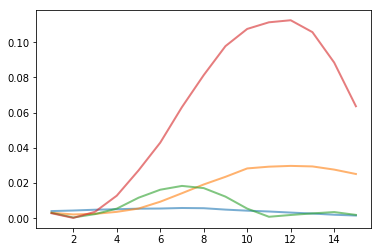

In [9]:
num_paths = 500
sigma_array = np.arange(0.01, 0.1, 0.03)
a = 0.1
timestep = 180
length = 15
forward_rate = 0.05
day_count = ql.Thirty360()
avg_grid_array = np.arange(12, timestep+1, 12)

spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

figure, axis = plt.subplots()
plots = []
zero_price_theory = np.array([spot_curve.discount(j*float(length)/float(timestep)) for j in avg_grid_array])

for sigma in sigma_array:
    term, zero_price_empirical = generare_paths_zero_price(spot_curve_handle, a, sigma, timestep, length, num_paths, avg_grid_array)
    plots += axis.plot(term, np.abs(zero_price_theory - np.array(zero_price_empirical)), lw=2, alpha=0.6, label="$\sigma=%.2f$" % sigma)

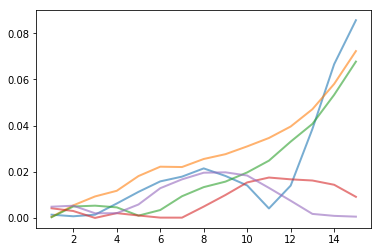

In [10]:
num_paths = 500
sigma = 0.1
a_array = np.arange(0.1, 0.51, 0.1)
timestep = 180
length = 15
forward_rate = 0.05
day_count = ql.Thirty360()
avg_grid_array = np.arange(12, timestep+1, 12)

spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

figure, axis = plt.subplots()
plots = []
zero_price_theory = np.array([spot_curve.discount(j*float(length)/float(timestep)) for j in avg_grid_array])

for a in a_array:
    term, zero_price_empirical = generare_paths_zero_price(spot_curve_handle, a, sigma, timestep, length, num_paths, avg_grid_array)
    plots += axis.plot(term, np.abs(zero_price_theory - np.array(zero_price_empirical)), lw=2, alpha=0.6, label="$a=%.2f$" % a)

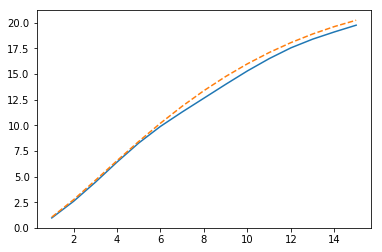

In [11]:
num_paths = 500
sigma = 0.02
a = 0.1
timestep = 180
length = 15
forward_rate = 0.05
day_count = ql.Thirty360()
avg_grid_array = np.arange(12, timestep+1, 12)

spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

term, discount_factor_matrix = generate_paths_discount_factors(spot_curve_handle, a, sigma, timestep, length, num_paths, avg_grid_array)
figure, axis = plt.subplots()

vol = [np.var(discount_factor_matrix[:, i]) for i in range(len(term))]
l1 = axis.plot(term, 100*np.sqrt(vol), "-")
vol_theory = [100*np.sqrt(math.exp(V(0, T, a, sigma)) - 1.0) * spot_curve_handle.discount(T) for T in term]
l2 = axis.plot(term, vol_theory, "--")
plots = l1 + l2